# RFECV multi-class prediction

In [1]:
import pathlib

import anndata
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix,
                             fbeta_score, make_scorer)
from sklearn.model_selection import StratifiedKFold

## Parameters

In [2]:
cluster_col = 'SubType'
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None

In [3]:
# Parameters
cluster_col = "SubType"
test_portion = 0.1
random_seed = 0
n_estimators = 100
n_estimators_final = 500
n_jobs = 30
n_splits = 5
cluster_order_path = None


In [4]:
output_dir = 'Model'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Marker Adata

In [5]:
adata = anndata.read_h5ad('Markers/cluster_markers.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 8167 × 182 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor', 'Replicate'
    var: 'chrom', 'start', 'end'

## Cluster Order

In [7]:
if cluster_order_path is not None:
    cluster_order = pd.read_csv(cluster_order_path, header=None, index_col=0).index
else:
    cluster_order = sorted(adata.obs[cluster_col].unique())

## Supervise training

In [8]:
n_cell = adata.shape[0]
n_test = int(n_cell * test_portion)

In [9]:
# separate test and train
test_cells = adata.obs.sample(n_test, random_state=random_seed).index
test_judge = adata.obs_names.isin(test_cells)
train_judge = ~adata.obs_names.isin(test_cells)

In [10]:
test_df = pd.DataFrame(adata[test_judge, :].X,
                       index=adata.obs_names[test_judge],
                       columns=adata.var_names)
test_label = adata.obs.loc[test_judge, cluster_col]

train_df = pd.DataFrame(adata[train_judge, :].X,
                        index=adata.obs_names[train_judge],
                        columns=adata.var_names)
train_label = adata.obs.loc[train_judge, cluster_col]

## Training

In [11]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=n_jobs,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=10)

In [12]:
clf.fit(train_df, train_label)
joblib.dump(clf, 'Model/RFECV.lib')

Fitting estimator with 182 features.
building tree 11 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 100
building tree 7 of 100
building tree 1 of 100
building tree 8 of 100
building tree 3 of 100
building tree 5 of 100building tree 19 of 100

building tree 9 of 100
building tree 17 of 100
building tree 16 of 100
building tree 14 of 100
building tree 27 of 100
building tree 10 of 100
building tree 4 of 100building tree 15 of 100
building tree 12 of 100
building tree 6 of 100

building tree 21 of 100building tree 22 of 100
building tree 24 of 100

building tree 18 of 100
building tree 28 of 100
building tree 13 of 100building tree 23 of 100

building tree 25 of 100
building tree 20 of 100
building tree 30 of 100
building tree 26 of 100
building tree 29 of 100
building tree 41 of 100
building tree 35 of 100
building tree 32 of 100
building tree 40 of 100building tree 34 of 100

building tree 31 of 100building tree 37 of 100

building tree 33 of 100
building tree 44 of 100
building tree 53 of 100
building tree 42 of 100building tree 38 of 100

building tree 39 of 100
b

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.7s finished


Fitting estimator with 179 features.


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 100
building tree 16 of 100
building tree 12 of 100
building tree 20 of 100
building tree 4 of 100
building tree 7 of 100building tree 14 of 100
building tree 8 of 100
building tree 10 of 100

building tree 3 of 100
building tree 17 of 100
building tree 21 of 100
building tree 11 of 100
building tree 29 of 100
building tree 15 of 100
building tree 23 of 100
building tree 25 of 100
building tree 9 of 100
building tree 19 of 100
building tree 27 of 100
building tree 2 of 100
building tree 6 of 100building tree 18 of 100building tree 28 of 100


building tree 22 of 100
building tree 30 of 100
building tree 5 of 100
building tree 24 of 100
building tree 13 of 100
building tree 26 of 100
building tree 31 of 100
building tree 34 of 100
building tree 32 of 100
building tree 42 of 100
building tree 45 of 100building tree 35 of 100

building tree 39 of 100
building tree 49 of 100building tree 33 of 100

building tree 38 of 100building tree 37 of 100building tree 36 of 100
bui

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.7s finished


Fitting estimator with 176 features.
building tree 2 of 100
building tree 6 of 100
building tree 7 of 100
building tree 3 of 100
building tree 1 of 100
building tree 4 of 100
building tree 8 of 100
building tree 22 of 100
building tree 13 of 100
building tree 10 of 100
building tree 14 of 100
building tree 16 of 100
building tree 5 of 100
building tree 9 of 100
building tree 15 of 100
building tree 11 of 100
building tree 12 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 23 of 100
building tree 27 of 100
building tree 29 of 100
building tree 20 of 100
building tree 28 of 100
building tree 26 of 100
building tree 17 of 100
building tree 21 of 100
building tree 24 of 100
building tree 25 of 100
building tree 30 of 100
building tree 32 of 100
building tree 31 of 100building tree 34 of 100

building tree 35 of 100
building tree 38 of 100building tree 33 of 100

building tree 45 of 100
building tree 36 of 100
building tree 41 of 100
building tree 37 of 100building tree 48 of 100building tree 42 of 100


building tree 55 of 100
building tree 47 of 100building tree 49 of 100
building tree 39 of 100
building tree 52 of 100
building tree 54 of 100building tree 44 of 100building tree 43 of 100



building tree 40 of 100building tree 53 of 100

building tree 50 of 100
building tree 46 of 100
building tree 56 of 100
building tree 51 of 100building tree 59 of 100
building tree 57 of 100

building tree 58 of 100
building tree 60 of 100
building tree 63

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


Fitting estimator with 173 features.
building tree 7 of 100building tree 3 of 100

building tree 1 of 100
building tree 6 of 100
building tree 9 of 100
building tree 8 of 100
building tree 4 of 100
building tree 10 of 100
building tree 2 of 100
building tree 5 of 100
building tree 14 of 100
building tree 13 of 100
building tree 22 of 100
building tree 24 of 100
building tree 15 of 100
building tree 11 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 16 of 100
building tree 19 of 100
building tree 29 of 100
building tree 18 of 100
building tree 12 of 100
building tree 17 of 100
building tree 28 of 100
building tree 20 of 100
building tree 25 of 100
building tree 30 of 100
building tree 23 of 100
building tree 27 of 100
building tree 21 of 100
building tree 26 of 100
building tree 31 of 100building tree 32 of 100

building tree 35 of 100building tree 34 of 100building tree 36 of 100


building tree 39 of 100
building tree 37 of 100building tree 38 of 100

building tree 40 of 100building tree 41 of 100

building tree 48 of 100
building tree 42 of 100building tree 47 of 100

building tree 46 of 100
building tree 33 of 100
building tree 54 of 100
building tree 45 of 100
building tree 51 of 100
building tree 49 of 100building tree 43 of 100

building tree 52 of 100
building tree 50 of 100
building tree 56 of 100
building tree 53 of 100building tree 44 of 100building tree 55 of 100


building tree 58 of 100building tree 57 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


Fitting estimator with 170 features.
building tree 2 of 100
building tree 1 of 100
building tree 13 of 100
building tree 4 of 100
building tree 14 of 100
building tree 3 of 100
building tree 10 of 100
building tree 8 of 100
building tree 9 of 100
building tree 11 of 100
building tree 6 of 100
building tree 7 of 100
building tree 23 of 100
building tree 12 of 100
building tree 15 of 100
building tree 17 of 100
building tree 19 of 100
building tree 18 of 100
building tree 29 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 30 of 100
building tree 21 of 100
building tree 16 of 100
building tree 22 of 100
building tree 24 of 100
building tree 26 of 100
building tree 28 of 100
building tree 5 of 100
building tree 20 of 100
building tree 25 of 100
building tree 27 of 100
building tree 31 of 100
building tree 37 of 100
building tree 32 of 100building tree 43 of 100

building tree 42 of 100building tree 33 of 100building tree 49 of 100


building tree 36 of 100
building tree 40 of 100
building tree 39 of 100building tree 45 of 100

building tree 53 of 100building tree 41 of 100

building tree 35 of 100building tree 34 of 100

building tree 47 of 100
building tree 38 of 100
building tree 54 of 100building tree 51 of 100
building tree 57 of 100
building tree 52 of 100

building tree 44 of 100
building tree 58 of 100
building tree 48 of 100
building tree 55 of 100building tree 56 of 100
building tree 46 of 100

building tree 50 of 100
building tree 59 of 100
building tree 60 of 100
building tree 62 

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.6s finished


Fitting estimator with 167 features.
building tree 11 of 100building tree 1 of 100

building tree 3 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 10 of 100
building tree 2 of 100
building tree 5 of 100
building tree 19 of 100
building tree 25 of 100
building tree 14 of 100
building tree 9 of 100
building tree 7 of 100
building tree 16 of 100
building tree 13 of 100
building tree 4 of 100
building tree 26 of 100building tree 8 of 100

building tree 6 of 100
building tree 17 of 100
building tree 28 of 100
building tree 12 of 100
building tree 24 of 100
building tree 15 of 100
building tree 23 of 100
building tree 20 of 100building tree 18 of 100

building tree 21 of 100
building tree 22 of 100
building tree 30 of 100
building tree 27 of 100
building tree 29 of 100
building tree 36 of 100
building tree 32 of 100
building tree 37 of 100building tree 35 of 100

building tree 31 of 100building tree 34 of 100

building tree 40 of 100
building tree 33 of 100
building tree 39 of 100
building tree 38 of 100building tree 42 of 100

building tree 50 of 100
building tree 44 of 100
building tree 41 of 100
building tree 48 of 100

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 164 features.
building tree 1 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 5 of 100
building tree 3 of 100
building tree 10 of 100
building tree 15 of 100
building tree 13 of 100
building tree 7 of 100
building tree 9 of 100
building tree 19 of 100
building tree 18 of 100
building tree 25 of 100
building tree 4 of 100
building tree 6 of 100
building tree 2 of 100
building tree 21 of 100
building tree 22 of 100
building tree 12 of 100
building tree 11 of 100
building tree 17 of 100
building tree 14 of 100
building tree 8 of 100
building tree 16 of 100building tree 23 of 100
building tree 28 of 100
building tree 26 of 100

building tree 24 of 100
building tree 29 of 100
building tree 20 of 100
building tree 30 of 100
building tree 27 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 39 of 100
building tree 35 of 100
building tree 37 of 100
building tree 41 of 100
building tree 38 of 100building tree 42 of 100

building tree 51 of 100building tree 44 of 100building tree 54 of 100
bu

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 161 features.
building tree 1 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 100
building tree 10 of 100
building tree 7 of 100building tree 4 of 100

building tree 12 of 100
building tree 6 of 100
building tree 23 of 100
building tree 8 of 100
building tree 11 of 100
building tree 9 of 100
building tree 5 of 100
building tree 18 of 100
building tree 13 of 100
building tree 16 of 100
building tree 15 of 100
building tree 22 of 100
building tree 28 of 100
building tree 3 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 27 of 100
building tree 25 of 100
building tree 14 of 100
building tree 17 of 100
building tree 26 of 100
building tree 24 of 100
building tree 30 of 100
building tree 29 of 100
building tree 31 of 100
building tree 35 of 100
building tree 32 of 100building tree 33 of 100

building tree 42 of 100
building tree 43 of 100
building tree 36 of 100building tree 37 of 100
building tree 46 of 100

building tree 34 of 100
building tree 38 of 100building tree 39 of 100
building tree 52 of 100
b

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 84 of 100
building tree 93 of 100
building tree 91 of 100
building tree 94 of 100building tree 92 of 100

building tree 100 of 100
building tree 96 of 100
building tree 97 of 100building tree 99 of 100

building tree 95 of 100
building tree 98 of 100
Fitting estimator with 158 features.
building tree 6 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 100building tree 1 of 100

building tree 4 of 100
building tree 5 of 100
building tree 7 of 100
building tree 9 of 100
building tree 8 of 100
building tree 19 of 100
building tree 14 of 100
building tree 23 of 100
building tree 11 of 100
building tree 22 of 100
building tree 13 of 100
building tree 3 of 100
building tree 25 of 100
building tree 16 of 100
building tree 20 of 100
building tree 21 of 100
building tree 17 of 100
building tree 29 of 100building tree 12 of 100
building tree 18 of 100

building tree 10 of 100
building tree 28 of 100
building tree 26 of 100
building tree 15 of 100
building tree 24 of 100
building tree 27 of 100
building tree 30 of 100
building tree 33 of 100
building tree 36 of 100
building tree 34 of 100
building tree 31 of 100
building tree 35 of 100
building tree 32 of 100
building tree 45 of 100
building tree 42 of 100
building tree 39 of 100
building tree 49 of 100
building tree 37 of 100
building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 80 of 100
building tree 83 of 100
building tree 85 of 100
building tree 91 of 100
building tree 94 of 100
building tree 95 of 100
building tree 92 of 100
building tree 93 of 100
building tree 98 of 100
building tree 96 of 100
building tree 99 of 100
building tree 97 of 100
building tree 100 of 100
Fitting estimator with 155 features.
building tree 1 of 100
building tree 4 of 100
building tree 9 of 100
building tree 7 of 100building tree 6 of 100



[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 19 of 100
building tree 10 of 100
building tree 2 of 100
building tree 11 of 100
building tree 14 of 100
building tree 13 of 100
building tree 12 of 100
building tree 3 of 100
building tree 16 of 100
building tree 8 of 100
building tree 18 of 100
building tree 22 of 100
building tree 5 of 100
building tree 28 of 100
building tree 29 of 100
building tree 31 of 100
building tree 23 of 100
building tree 15 of 100
building tree 27 of 100
building tree 25 of 100
building tree 20 of 100
building tree 21 of 100
building tree 17 of 100
building tree 24 of 100
building tree 26 of 100
building tree 30 of 100
building tree 33 of 100
building tree 39 of 100
building tree 32 of 100
building tree 34 of 100
building tree 37 of 100
building tree 41 of 100
building tree 36 of 100building tree 42 of 100

building tree 43 of 100building tree 35 of 100

building tree 38 of 100
building tree 46 of 100
building tree 44 of 100
building tree 40 of 100
building tree 50 of 100building tree 49 of 1

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 93 of 100
building tree 94 of 100
building tree 98 of 100
building tree 99 of 100
building tree 95 of 100
building tree 100 of 100
building tree 96 of 100
building tree 97 of 100
Fitting estimator with 152 features.
building tree 4 of 100
building tree 6 of 100building tree 11 of 100

building tree 15 of 100
building tree 26 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 100
building tree 5 of 100
building tree 2 of 100
building tree 25 of 100
building tree 3 of 100
building tree 9 of 100
building tree 21 of 100
building tree 29 of 100
building tree 27 of 100
building tree 12 of 100
building tree 8 of 100
building tree 18 of 100
building tree 7 of 100
building tree 16 of 100
building tree 23 of 100
building tree 10 of 100
building tree 19 of 100
building tree 22 of 100
building tree 28 of 100
building tree 17 of 100
building tree 14 of 100
building tree 13 of 100building tree 24 of 100

building tree 30 of 100
building tree 20 of 100
building tree 36 of 100
building tree 34 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 35 of 100
building tree 40 of 100
building tree 42 of 100
building tree 38 of 100building tree 37 of 100building tree 44 of 100building tree 50 of 100

building tree 47 of 100

building tree 41 of 100

building tree 55 of 100building tree 39 of 100

building tree 43 of 100

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 90 of 100
building tree 92 of 100
building tree 91 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 98 of 100
building tree 97 of 100
building tree 96 of 100
building tree 100 of 100
building tree 99 of 100
Fitting estimator with 149 features.


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 100
building tree 13 of 100
building tree 3 of 100
building tree 5 of 100
building tree 18 of 100
building tree 4 of 100
building tree 10 of 100
building tree 7 of 100
building tree 15 of 100
building tree 21 of 100
building tree 9 of 100
building tree 22 of 100
building tree 16 of 100
building tree 11 of 100
building tree 17 of 100
building tree 24 of 100
building tree 20 of 100
building tree 19 of 100
building tree 2 of 100
building tree 27 of 100
building tree 14 of 100
building tree 6 of 100
building tree 29 of 100
building tree 28 of 100
building tree 25 of 100
building tree 12 of 100
building tree 26 of 100
building tree 8 of 100
building tree 30 of 100
building tree 23 of 100
building tree 35 of 100
building tree 34 of 100
building tree 41 of 100
building tree 37 of 100
building tree 31 of 100
building tree 32 of 100
building tree 40 of 100building tree 45 of 100building tree 48 of 100


building tree 46 of 100building tree 36 of 100

building tree 44 of 100
b

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.8s finished


building tree 92 of 100
building tree 91 of 100
building tree 96 of 100
building tree 97 of 100building tree 95 of 100building tree 99 of 100
building tree 93 of 100
building tree 98 of 100


building tree 100 of 100
building tree 94 of 100
Fitting estimator with 146 features.
building tree 5 of 100
building tree 8 of 100
building tree 16 of 100
building tree 13 of 100
building tree 9 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 3 of 100
building tree 2 of 100
building tree 4 of 100
building tree 15 of 100
building tree 12 of 100
building tree 6 of 100
building tree 26 of 100
building tree 10 of 100building tree 23 of 100

building tree 18 of 100
building tree 19 of 100
building tree 7 of 100
building tree 1 of 100
building tree 20 of 100
building tree 17 of 100
building tree 22 of 100
building tree 11 of 100
building tree 21 of 100
building tree 30 of 100
building tree 14 of 100
building tree 27 of 100
building tree 29 of 100
building tree 25 of 100building tree 28 of 100

building tree 24 of 100
building tree 39 of 100
building tree 34 of 100
building tree 32 of 100
building tree 37 of 100
building tree 35 of 100
building tree 33 of 100
building tree 36 of 100
building tree 31 of 100building tree 49 of 100

building tree 47 of 100building tree 45 of 100

building tree 42 of 100
building tree 38 of 100
building tree 52 of 100
building tree 46 of 100
building tree 48 of 100
building tree 41 of 10

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 92 of 100
building tree 93 of 100
building tree 94 of 100building tree 96 of 100building tree 95 of 100

building tree 99 of 100

building tree 97 of 100
building tree 98 of 100
building tree 100 of 100
Fitting estimator with 143 features.
building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 3 of 100
building tree 8 of 100
building tree 5 of 100
building tree 6 of 100
building tree 4 of 100
building tree 7 of 100
building tree 13 of 100
building tree 10 of 100
building tree 15 of 100building tree 9 of 100

building tree 11 of 100
building tree 22 of 100
building tree 20 of 100
building tree 14 of 100
building tree 18 of 100
building tree 24 of 100
building tree 12 of 100
building tree 26 of 100
building tree 19 of 100
building tree 16 of 100
building tree 23 of 100
building tree 21 of 100building tree 27 of 100

building tree 25 of 100
building tree 17 of 100
building tree 30 of 100
building tree 29 of 100
building tree 28 of 100
building tree 32 of 100
building tree 31 of 100
building tree 33 of 100
building tree 37 of 100building tree 39 of 100

building tree 34 of 100
building tree 42 of 100
building tree 38 of 100
building tree 43 of 100building tree 35 of 100building tree 36 of 100


building tree 41 of 100building tree 45 of 100
building tree 44 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 140 features.
building tree 1 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 100
building tree 9 of 100
building tree 4 of 100
building tree 6 of 100
building tree 13 of 100
building tree 8 of 100
building tree 7 of 100
building tree 18 of 100
building tree 28 of 100
building tree 3 of 100
building tree 24 of 100
building tree 14 of 100
building tree 17 of 100
building tree 15 of 100building tree 19 of 100
building tree 23 of 100

building tree 25 of 100
building tree 10 of 100
building tree 21 of 100
building tree 5 of 100
building tree 11 of 100building tree 20 of 100
building tree 26 of 100

building tree 16 of 100
building tree 27 of 100
building tree 29 of 100
building tree 30 of 100
building tree 22 of 100
building tree 12 of 100
building tree 33 of 100
building tree 31 of 100
building tree 43 of 100
building tree 36 of 100
building tree 44 of 100
building tree 32 of 100building tree 34 of 100

building tree 39 of 100
building tree 42 of 100building tree 45 of 100

building tree 37 of 100
building tree 46 of 100
building tree 35 of 100b

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 137 features.


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 9 of 100
building tree 14 of 100
building tree 3 of 100
building tree 24 of 100
building tree 5 of 100
building tree 11 of 100
building tree 7 of 100
building tree 8 of 100
building tree 4 of 100
building tree 13 of 100
building tree 25 of 100
building tree 1 of 100building tree 15 of 100
building tree 29 of 100

building tree 26 of 100
building tree 16 of 100
building tree 20 of 100
building tree 2 of 100
building tree 22 of 100
building tree 12 of 100
building tree 6 of 100
building tree 30 of 100
building tree 18 of 100
building tree 10 of 100
building tree 27 of 100
building tree 19 of 100
building tree 28 of 100
building tree 17 of 100
building tree 23 of 100
building tree 21 of 100
building tree 36 of 100
building tree 39 of 100
building tree 33 of 100
building tree 44 of 100
building tree 34 of 100
building tree 35 of 100building tree 46 of 100
building tree 41 of 100building tree 54 of 100

building tree 50 of 100
building tree 40 of 100
building tree 37 of 100

b

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.8s finished



building tree 95 of 100
building tree 96 of 100
building tree 93 of 100
building tree 92 of 100
building tree 99 of 100building tree 98 of 100

building tree 100 of 100
building tree 97 of 100
Fitting estimator with 134 features.
building tree 4 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 9 of 100
building tree 5 of 100
building tree 2 of 100
building tree 3 of 100
building tree 1 of 100
building tree 13 of 100
building tree 6 of 100
building tree 7 of 100
building tree 17 of 100
building tree 8 of 100
building tree 14 of 100
building tree 29 of 100
building tree 18 of 100building tree 15 of 100
building tree 23 of 100
building tree 12 of 100

building tree 24 of 100
building tree 22 of 100
building tree 21 of 100
building tree 10 of 100
building tree 19 of 100
building tree 16 of 100
building tree 26 of 100
building tree 20 of 100
building tree 11 of 100
building tree 30 of 100
building tree 27 of 100
building tree 28 of 100
building tree 25 of 100
building tree 31 of 100
building tree 42 of 100
building tree 37 of 100
building tree 34 of 100building tree 41 of 100

building tree 33 of 100
building tree 32 of 100
building tree 36 of 100building tree 43 of 100

building tree 40 of 100building tree 51 of 100
building tree 47 of 100

building tree 39 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 91 of 100
building tree 96 of 100
building tree 92 of 100
building tree 93 of 100
building tree 95 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100building tree 94 of 100

Fitting estimator with 131 features.
building tree 1 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 4 of 100
building tree 6 of 100
building tree 11 of 100
building tree 2 of 100
building tree 22 of 100
building tree 13 of 100
building tree 10 of 100
building tree 9 of 100
building tree 3 of 100
building tree 16 of 100
building tree 19 of 100
building tree 7 of 100
building tree 18 of 100
building tree 17 of 100
building tree 15 of 100
building tree 5 of 100
building tree 8 of 100
building tree 23 of 100
building tree 29 of 100
building tree 14 of 100
building tree 26 of 100
building tree 28 of 100
building tree 21 of 100
building tree 24 of 100
building tree 27 of 100
building tree 20 of 100
building tree 12 of 100
building tree 25 of 100
building tree 30 of 100
building tree 44 of 100
building tree 34 of 100
building tree 33 of 100
building tree 36 of 100
building tree 32 of 100building tree 37 of 100building tree 39 of 100
building tree 47 of 100


building tree 42 of 100
building tree 31 of 100building tree 45 of 100building tree 35 of 100
building tree 52 of 100




[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 91 of 100
building tree 94 of 100
building tree 93 of 100
building tree 98 of 100
building tree 97 of 100
building tree 92 of 100
building tree 95 of 100
building tree 100 of 100
building tree 96 of 100
building tree 99 of 100
Fitting estimator with 128 features.
building tree 2 of 100
building tree 3 of 100
building tree 10 of 100
building tree 6 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 13 of 100
building tree 11 of 100
building tree 4 of 100
building tree 5 of 100
building tree 7 of 100
building tree 1 of 100
building tree 9 of 100
building tree 17 of 100
building tree 16 of 100
building tree 14 of 100
building tree 20 of 100
building tree 8 of 100
building tree 23 of 100
building tree 24 of 100
building tree 18 of 100
building tree 25 of 100
building tree 29 of 100
building tree 19 of 100
building tree 12 of 100
building tree 28 of 100
building tree 22 of 100
building tree 21 of 100
building tree 30 of 100
building tree 27 of 100
building tree 26 of 100
building tree 15 of 100
building tree 34 of 100building tree 32 of 100

building tree 31 of 100
building tree 33 of 100building tree 38 of 100

building tree 35 of 100
building tree 36 of 100building tree 41 of 100

building tree 37 of 100
building tree 44 of 100
building tree 40 of 100building tree 54 of 100

building tree 45 of 100building tree 42 of 100
building tree 52 of 100

building tree 53 of 10

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.8s finished


Fitting estimator with 125 features.
building tree 1 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 3 of 100
building tree 9 of 100
building tree 11 of 100
building tree 4 of 100
building tree 6 of 100
building tree 5 of 100
building tree 7 of 100
building tree 21 of 100
building tree 13 of 100building tree 2 of 100

building tree 16 of 100
building tree 12 of 100
building tree 18 of 100
building tree 17 of 100
building tree 23 of 100
building tree 10 of 100
building tree 28 of 100
building tree 8 of 100
building tree 20 of 100
building tree 22 of 100
building tree 19 of 100
building tree 24 of 100
building tree 26 of 100
building tree 27 of 100
building tree 25 of 100
building tree 15 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 14 of 100
building tree 32 of 100
building tree 33 of 100
building tree 45 of 100
building tree 34 of 100building tree 38 of 100building tree 50 of 100


building tree 35 of 100
building tree 40 of 100building tree 37 of 100building tree 42 of 100

building tree 44 of 100

building tree 54 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.8s finished


building tree 92 of 100
building tree 93 of 100
building tree 96 of 100
building tree 100 of 100building tree 95 of 100building tree 98 of 100


building tree 97 of 100
building tree 94 of 100
building tree 99 of 100
Fitting estimator with 122 features.


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 4 of 100
building tree 2 of 100
building tree 3 of 100building tree 1 of 100

building tree 7 of 100
building tree 8 of 100
building tree 22 of 100
building tree 11 of 100
building tree 10 of 100
building tree 5 of 100
building tree 9 of 100
building tree 6 of 100
building tree 23 of 100
building tree 12 of 100
building tree 14 of 100
building tree 18 of 100
building tree 21 of 100
building tree 24 of 100
building tree 27 of 100
building tree 25 of 100
building tree 26 of 100building tree 15 of 100
building tree 28 of 100

building tree 19 of 100
building tree 13 of 100
building tree 17 of 100
building tree 30 of 100
building tree 16 of 100
building tree 20 of 100
building tree 29 of 100
building tree 32 of 100
building tree 33 of 100
building tree 31 of 100
building tree 35 of 100building tree 34 of 100

building tree 44 of 100
building tree 38 of 100building tree 36 of 100
building tree 37 of 100

building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
b

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 90 of 100
building tree 91 of 100
building tree 93 of 100building tree 96 of 100

building tree 92 of 100
building tree 100 of 100
building tree 99 of 100
building tree 94 of 100
building tree 95 of 100building tree 98 of 100

building tree 97 of 100
Fitting estimator with 119 features.


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 9 of 100
building tree 10 of 100
building tree 4 of 100
building tree 8 of 100
building tree 16 of 100
building tree 17 of 100
building tree 23 of 100
building tree 6 of 100
building tree 15 of 100building tree 14 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100

building tree 5 of 100
building tree 19 of 100
building tree 18 of 100
building tree 27 of 100building tree 20 of 100

building tree 24 of 100
building tree 7 of 100
building tree 25 of 100
building tree 28 of 100
building tree 21 of 100
building tree 29 of 100
building tree 22 of 100
building tree 30 of 100
building tree 26 of 100
building tree 31 of 100
building tree 32 of 100
building tree 34 of 100
building tree 46 of 100
building tree 42 of 100
building tree 39 of 100
building tree 36 of 100building tree 35 of 100
building tree 43 of 100

building tree 37 of 100building tree 33 of 100

building tree 41 of 100
b

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 116 features.
building tree 1 of 100
building tree 3 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 6 of 100
building tree 14 of 100
building tree 7 of 100
building tree 9 of 100
building tree 17 of 100
building tree 4 of 100
building tree 12 of 100
building tree 13 of 100
building tree 8 of 100
building tree 2 of 100
building tree 15 of 100building tree 11 of 100

building tree 18 of 100
building tree 10 of 100
building tree 16 of 100
building tree 26 of 100
building tree 5 of 100
building tree 21 of 100
building tree 23 of 100
building tree 22 of 100
building tree 20 of 100
building tree 25 of 100
building tree 27 of 100
building tree 30 of 100
building tree 29 of 100
building tree 28 of 100
building tree 24 of 100
building tree 19 of 100
building tree 31 of 100
building tree 35 of 100
building tree 37 of 100
building tree 32 of 100building tree 34 of 100

building tree 33 of 100
building tree 43 of 100building tree 36 of 100

building tree 44 of 100
building tree 39 of 100
building tree 41 of 100building tree 42 of 100

building tree 49 of 100
building tree 54 of 100

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 89 of 100building tree 91 of 100

building tree 94 of 100
building tree 93 of 100
building tree 95 of 100
building tree 92 of 100
building tree 97 of 100
building tree 96 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
Fitting estimator with 113 features.
building tree 1 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 8 of 100
building tree 7 of 100
building tree 5 of 100
building tree 4 of 100
building tree 19 of 100
building tree 14 of 100
building tree 12 of 100
building tree 2 of 100
building tree 10 of 100building tree 20 of 100

building tree 6 of 100
building tree 26 of 100
building tree 3 of 100
building tree 16 of 100
building tree 9 of 100
building tree 18 of 100
building tree 25 of 100
building tree 15 of 100
building tree 22 of 100
building tree 23 of 100
building tree 17 of 100
building tree 11 of 100
building tree 28 of 100
building tree 13 of 100
building tree 27 of 100
building tree 29 of 100
building tree 24 of 100
building tree 21 of 100
building tree 30 of 100
building tree 31 of 100building tree 38 of 100

building tree 33 of 100
building tree 35 of 100
building tree 34 of 100building tree 37 of 100
building tree 32 of 100

building tree 43 of 100building tree 36 of 100

building tree 39 of 100
building tree 48 of 100building tree 40 of 100

building tree 41 of 100


[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished


building tree 89 of 100
building tree 94 of 100
building tree 93 of 100building tree 95 of 100

building tree 98 of 100
building tree 97 of 100
building tree 96 of 100
building tree 99 of 100
building tree 100 of 100building tree 91 of 100

building tree 92 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 2 of 100
building tree 17 of 100
building tree 3 of 100
building tree 8 of 100
building tree 1 of 100
building tree 6 of 100
building tree 22 of 100
building tree 7 of 100
building tree 16 of 100
building tree 11 of 100building tree 10 of 100
building tree 12 of 100

building tree 29 of 100
building tree 4 of 100
building tree 5 of 100
building tree 24 of 100
building tree 13 of 100
building tree 26 of 100
building tree 23 of 100
building tree 9 of 100
building tree 14 of 100
building tree 19 of 100
building tree 20 of 100
building tree 15 of 100
building tree 18 of 100
building tree 28 of 100
building tree 30 of 100
building tree 27 of 100
building tree 25 of 100
building tree 21 of 100
building tree 36 of 100
building tree 37 of 100
building tree 32 of 100
building tree 31 of 100
building tree 45 of 100
building tree 33 of 100
building tree 38 of 100building tree 35 of 100

building tree 48 of 100
building tree 40 of 100
building tree 43 of 100building tree 44 of 100

b

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.9s finished



building tree 90 of 100
building tree 95 of 100
building tree 93 of 100
building tree 94 of 100building tree 92 of 100

building tree 91 of 100
building tree 99 of 100
building tree 96 of 100
building tree 98 of 100
building tree 97 of 100
building tree 100 of 100


[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 8 of 100building tree 6 of 100

building tree 5 of 100
building tree 3 of 100
building tree 10 of 100
building tree 27 of 100
building tree 1 of 100
building tree 16 of 100
building tree 20 of 100building tree 29 of 100

building tree 30 of 100
building tree 15 of 100
building tree 11 of 100
building tree 17 of 100
building tree 14 of 100
building tree 12 of 100
building tree 9 of 100
building tree 2 of 100
building tree 7 of 100
building tree 28 of 100
building tree 22 of 100
building tree 13 of 100
building tree 25 of 100
building tree 18 of 100
building tree 24 of 100
building tree 23 of 100
building tree 4 of 100
building tree 26 of 100
building tree 19 of 100
building tree 21 of 100
building tree 31 of 100
building tree 34 of 100
building tree 38 of 100building tree 53 of 100
building tree 42 of 100

building tree 39 of 100
building tree 32 of 100
building tree 33 of 100building tree 40 of 100
building tree 35 of 100

building tree 43 of 100building tree 44 of 100

b

[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.8s finished


building tree 100 of 100


['Model/RFECV.lib']

## Featurs

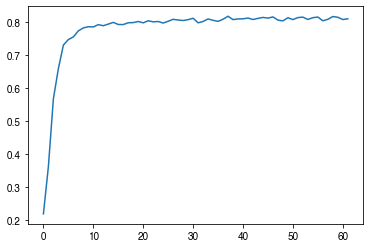

In [13]:
plt.plot(clf.grid_scores_)

In [14]:
feature_to_use = train_df.columns[clf.support_]
print(feature_to_use.size, 'features selected by RFECV')

110 features selected by RFECV


In [15]:
adata.var.loc[feature_to_use].to_csv('Model/ModelFeature.csv')

## Testing

In [16]:
# final pred
pred_label = clf.predict(test_df)

# final pred proba
pred_proba = clf.predict_proba(test_df)
pred_proba = pd.DataFrame(pred_proba, index=test_df.index, columns=clf.classes_)
pred_proba = pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  75 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.0s finished


In [17]:
balanced_accuracy_score(test_label, pred_label)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.7954973000115323

## Confusion matrix

In [18]:
cfm = confusion_matrix(test_label, pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 16)]

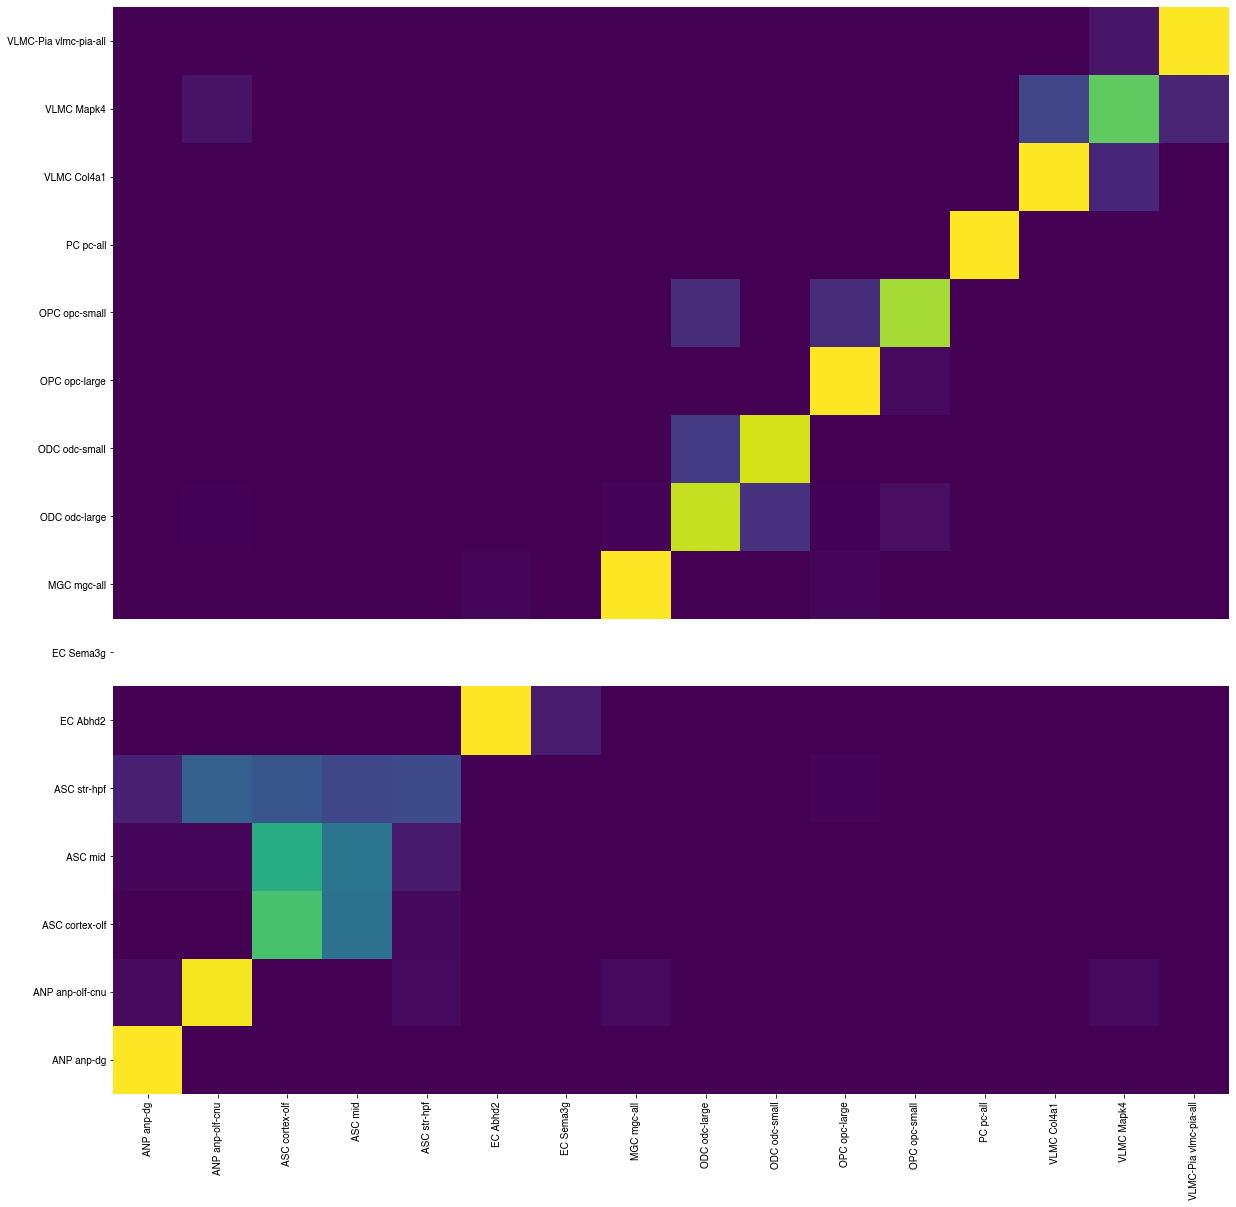

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [20]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = pred_proba.iloc[test_orders.argsort(), :]

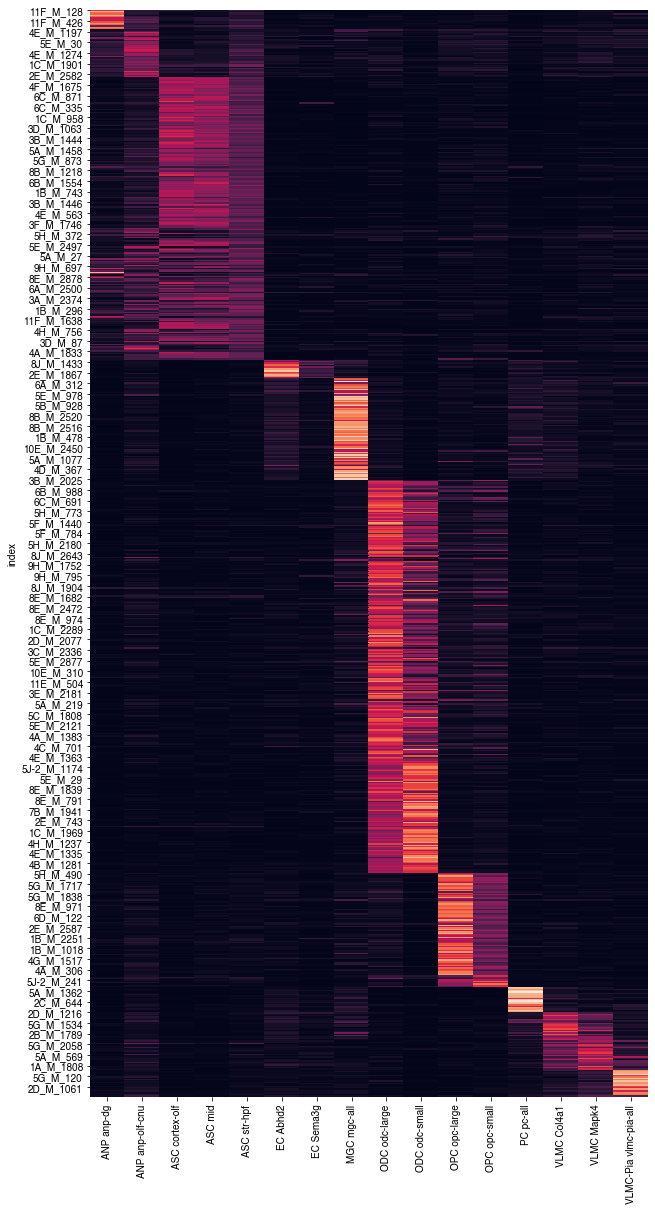

In [21]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

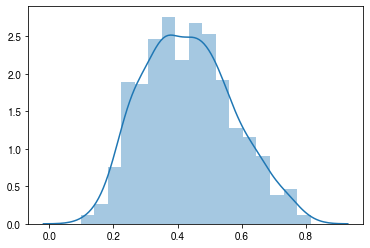

In [22]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

## Train final model with RFECV selected feature

In [23]:
selected_train_df = train_df.loc[:, feature_to_use]
selected_test_df = test_df.loc[:, feature_to_use]

In [24]:
# final estimator with larger trees
final_estimator = BalancedRandomForestClassifier(n_estimators=n_estimators_final,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 min_samples_split=2,
                                                 min_samples_leaf=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 bootstrap=True,
                                                 oob_score=False,
                                                 sampling_strategy='auto',
                                                 replacement=False,
                                                 n_jobs=n_jobs,
                                                 random_state=random_seed,
                                                 verbose=3,
                                                 warm_start=False,
                                                 class_weight=None)

In [25]:
final_estimator.fit(selected_train_df, train_label)
joblib.dump(final_estimator, 'Model/FinalClassifier.lib')

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


building tree 11 of 500building tree 2 of 500

building tree 7 of 500
building tree 14 of 500
building tree 10 of 500
building tree 6 of 500
building tree 16 of 500
building tree 8 of 500
building tree 13 of 500
building tree 3 of 500
building tree 1 of 500
building tree 12 of 500
building tree 18 of 500
building tree 15 of 500
building tree 5 of 500
building tree 20 of 500
building tree 17 of 500
building tree 9 of 500
building tree 29 of 500
building tree 19 of 500
building tree 4 of 500
building tree 22 of 500
building tree 23 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 21 of 500
building tree 28 of 500
building tree 30 of 500
building tree 24 of 500
building tree 36 of 500
building tree 38 of 500building tree 32 of 500
building tree 34 of 500

building tree 35 of 500
building tree 31 of 500building tree 33 of 500

building tree 37 of 500
building tree 40 of 500
building tree 39 of 500
building tree 42 of 500
building tree 47 of 500
b

[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.8s


building tree 102 of 500
building tree 101 of 500building tree 112 of 500building tree 98 of 500

building tree 108 of 500

building tree 105 of 500
building tree 111 of 500building tree 110 of 500building tree 107 of 500building tree 118 of 500



building tree 100 of 500
building tree 104 of 500building tree 103 of 500

building tree 115 of 500building tree 113 of 500

building tree 117 of 500
building tree 106 of 500
building tree 109 of 500
building tree 116 of 500
building tree 119 of 500
building tree 114 of 500
building tree 120 of 500building tree 121 of 500

building tree 123 of 500
building tree 125 of 500
building tree 122 of 500
building tree 124 of 500
building tree 132 of 500building tree 134 of 500

building tree 133 of 500
building tree 138 of 500
building tree 128 of 500
building tree 126 of 500
building tree 130 of 500
building tree 127 of 500building tree 129 of 500
building tree 139 of 500

building tree 131 of 500
building tree 144 of 500
building tree 135 of 500
b

[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    2.1s


building tree 255 of 500
building tree 254 of 500
building tree 260 of 500
building tree 277 of 500building tree 258 of 500building tree 256 of 500


building tree 262 of 500
building tree 259 of 500
building tree 261 of 500
building tree 263 of 500
building tree 264 of 500
building tree 266 of 500
building tree 268 of 500building tree 270 of 500

building tree 267 of 500building tree 269 of 500

building tree 265 of 500
building tree 278 of 500
building tree 271 of 500building tree 272 of 500

building tree 273 of 500
building tree 276 of 500
building tree 274 of 500
building tree 275 of 500
building tree 280 of 500
building tree 279 of 500
building tree 283 of 500
building tree 284 of 500
building tree 281 of 500
building tree 282 of 500
building tree 288 of 500building tree 285 of 500building tree 287 of 500


building tree 289 of 500
building tree 286 of 500building tree 293 of 500

building tree 292 of 500
building tree 290 of 500
building tree 295 of 500
building tree 296 of 500


[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    4.3s finished


['Model/FinalClassifier.lib']

## Final Pred

In [26]:
final_pred_label = final_estimator.predict(selected_test_df)

final_pred_proba = final_estimator.predict_proba(selected_test_df)
final_pred_proba = pd.DataFrame(final_pred_proba, index=test_df.index, columns=clf.classes_)
final_pred_proba = final_pred_proba[cluster_order].copy()

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.1s finished


In [27]:
balanced_accuracy_score(test_label, final_pred_label)

0.824882499770995

## Final evaluate

In [28]:
cfm = confusion_matrix(test_label, final_pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 16)]

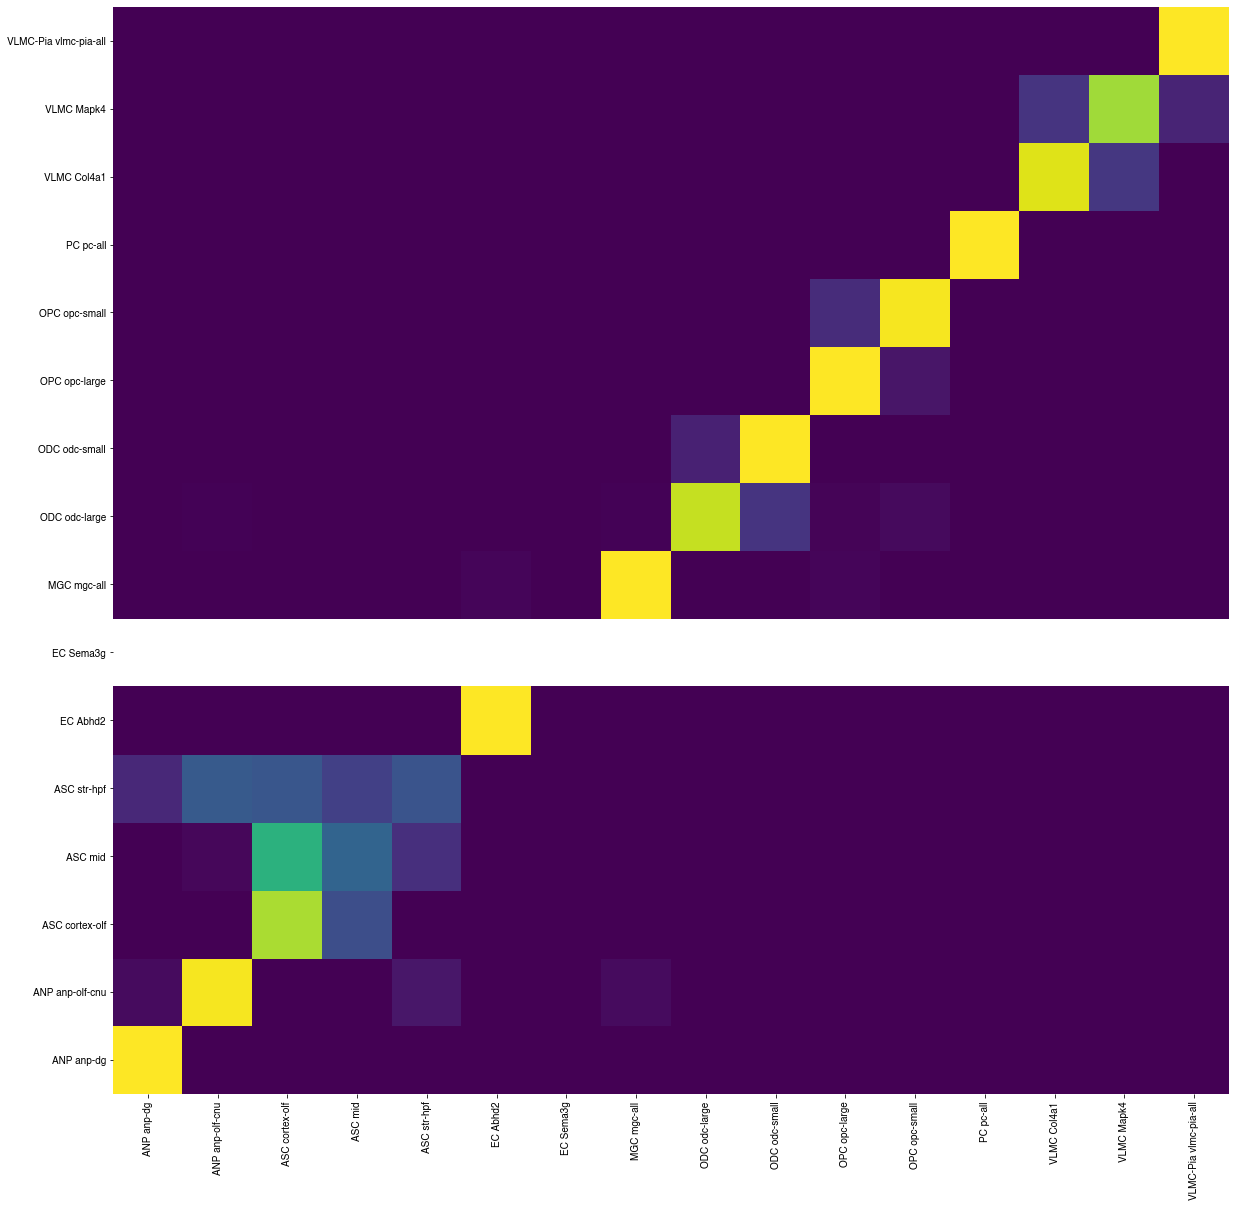

In [29]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [30]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = final_pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = final_pred_proba.iloc[test_orders.argsort(), :]

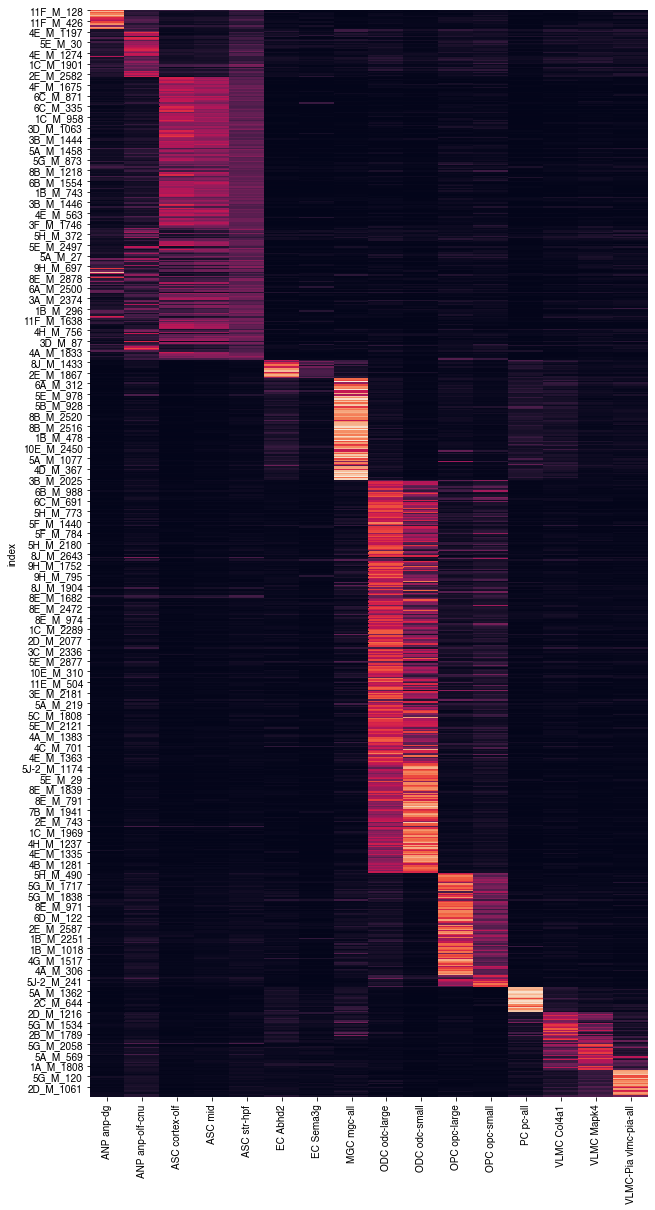

In [31]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

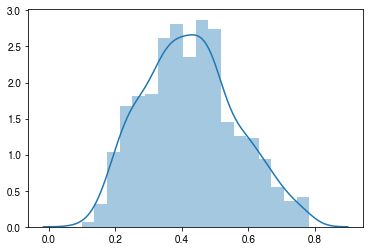

In [32]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

In [33]:
with open('finish_flag', 'w') as f:
    f.write('Oh yeah')

## Use model

In [34]:
# example
import joblib

# load data, model and feature
feature_to_use = pd.read_csv('Model/ModelFeature.csv', index_col=0)
adata = anndata.read_h5ad('Adata/cell_by_feature.cov_filter.rate.h5ad')
clf = joblib.load('Model/FinalClassifier.lib')

# make sure all feature exists
feature_var = adata.var.reindex(feature_to_use.index.astype(str))
assert feature_var['chrom'].isna().sum() == 0
adata = adata[:, feature_var.index]

# predict
predicted_label = pd.Series(clf.predict(adata.X), index=adata.obs_names)

# test if possible
true_label = adata.obs[cluster_col]
balanced_accuracy_score(true_label, predicted_label)

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:    0.0s
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed:    0.1s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.2s finished


0.8595180217636103